# Classifying Partisan Bias in News Articles

## Introduction
I am using a dataset that was used in a competition on hyperpartisan news detection. It contains 750k articles from online news sources tagged for bias across a "left"/"right" political spectrum. I was interested in this dataset for  its potential in assisting with media literacy. I am skeptical of the value of classification across 1-dimensional political spectrum being a helpful tool, but the first step in addressing my skepticism is understanding the approach, hence my interest in this dataset.

See also:
- Link to dataset: [Data for PAN at SemEval 2019 Task 4: Hyperpartisan News Detection](https://zenodo.org/records/1489920)
- About the dataset: [Hyperpartisan News Detection 2019](https://pan.webis.de/semeval19/semeval19-web/#data)
- (Very) detailed documentation about the dataset, via the paper the introduced it: [SemEval-2019 Task 4: Hyperpartisan News Detection](https://aclanthology.org/S19-2145.pdf)
- I will only use a portion of the dataset, and will highlight aspects of it, below
- Specifically, I am attempting to replicate some of the methods used in [Classifying Partisan Bias in News Articles:
 Leveraging an Understanding of Political Language
 and Article Structure](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1234/final-reports/final-report-169502805.pdf)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, TextVectorization
from tensorflow.keras.preprocessing import sequence

import xgboost as xgb
from xgboost import XGBClassifier

def dataset_file_path(fname):
    return os.path.join(os.path.join(os.getcwd(), "dataset", fname))

2025-08-24 19:02:06.625668: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Comments
 - The dataset is downloaded to, and prepared in, the `dataset` dir using [this script (github)](https://github.com/adhavle/hyperpartisan-news-detection/blob/main/download-and-clean-data.ipynb)
 - `articles-validation-bypublisher-20181122-html-escaped.xml` contains a list of 150,000 news articles (sourced online)
    - The dataset contains ~600k more articles (the training corpus) but I'll just use the validation set for this exercise.
    - I will actually halve the validation dataset and use 75,000 articles, in an 80/20 test/train split.
 - `ground-truth-validation-bypublisher-20181122.xml` contains the targets for these articles
 - Targets are `left`, `left-center`, `least`, `right-center`, `right`

In [2]:
training_data_file = dataset_file_path("articles-validation-bypublisher-20181122-html-escaped.xml")
target_data_file = dataset_file_path("ground-truth-validation-bypublisher-20181122.xml")

In [3]:
datadf = pd.read_xml(path_or_buffer = training_data_file)
targetdf = pd.read_xml(path_or_buffer = target_data_file)
df = pd.concat([datadf, targetdf], axis = 1)
df.columns = [
    'id',
    'published-at',
    'title',
    'article',
    'id2',
    'hyperpartisan',
    'bias',
    'url',
    'labeled-by'
]

#### Comments
- Training data and targets are now in a single dataframe.
- There should be 150,000 articles
- The `id` field from training and target sets should match
- No record should have an empty `article` or `bias` field
- Running some test cases for data hygiene

In [4]:
# run some test cases to ensure the data is good
if len(df) == 150_000:
    print(f"PASS: dataframe has {len(df)} records as expected")
else:
    print(f"FAIL: dataframe has {len(df)} records - expected 150,000")

def validate_column_does_not_have_null_values(column_name):
    if df[column_name].isnull().sum() == 0:
        print(f"PASS: no null values detected for column '{column_name}'")
    else:
        print(f"FAIL: {df[column_name].isnull().sum()} null values for column '{column_name}' not expected")

validate_column_does_not_have_null_values("id")
validate_column_does_not_have_null_values("id2")
validate_column_does_not_have_null_values("article")
validate_column_does_not_have_null_values("bias")

id_matches = df['id'] == df['id2']
n_not_matched = id_matches.value_counts().get(False, 0)
n_matched = id_matches.value_counts().get(True, 0)
if n_matched == 150_000 and n_not_matched == 0:
    print(f"PASS: all article IDs from training file and target file matched (id == id2 for all records)")
else:
    print(f"FAIL: {n_matched} article IDs from training file matched, BUT {n_not_matched} article IDs did not match")

PASS: dataframe has 150000 records as expected
PASS: no null values detected for column 'id'
PASS: no null values detected for column 'id2'
PASS: no null values detected for column 'article'
PASS: no null values detected for column 'bias'
PASS: all article IDs from training file and target file matched (id == id2 for all records)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             150000 non-null  int64 
 1   published-at   100492 non-null  object
 2   title          137723 non-null  object
 3   article        150000 non-null  object
 4   id2            150000 non-null  int64 
 5   hyperpartisan  150000 non-null  bool  
 6   bias           150000 non-null  object
 7   url            150000 non-null  object
 8   labeled-by     150000 non-null  object
dtypes: bool(1), int64(2), object(6)
memory usage: 9.3+ MB


#### Comments
 - The `bias` column is the target
 - `hyperpartisan` column is related to `bias`
 - Later I'll inspect the range of values for `bias`, and how they map to `hyperpartisan`

In [6]:
# Using train_test_split to halve the dataset size
# The dataset is balanced across bias categories, so just splitting it in half (stratified by bias) should be fine.
# But we'll inspect the data post-split to understand the distribution and ensure it is still balanced
df, _, _, _ = train_test_split(
    df,
    df['bias'],
    test_size=0.5,
    random_state=42,
    stratify=df['bias'])

df.reset_index(drop = True, inplace = True)

In [7]:
# Mapping for converting the bias text labels to numeric values

bias_mapping = {'left': 0, 'left-center': 1, 'least': 2, 'right-center': 3, 'right': 4 }
bias_mapping_reverse = dict((v,k) for k,v in bias_mapping.items())
df['bias'] = df['bias'].map(bias_mapping)

#### Comments
- Exploring the data:
- Next couple of cells will show the distribution of articles in each bias category, across the dataset
- The same distribution, broken down by `hyperpartisan = true|false` will highlight that `hyperpartisan=true` maps to `bias` being `left` or `right` (as opposed to `left-center`, `least`, or `right-center`)
- Given that, I will focus on training models to predict the `bias` class, which is sufficient to infer if the article is considered hyperpartisan.

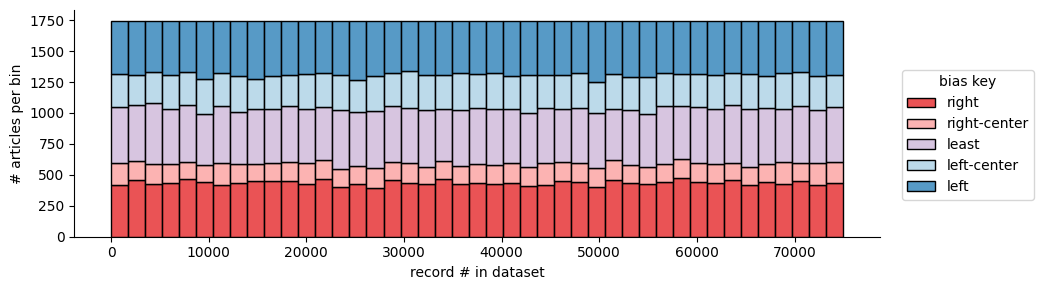

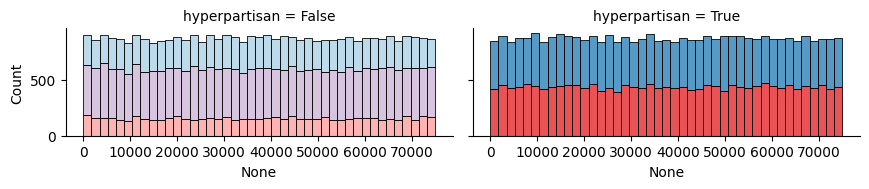

,hyperpartisan,bias,count
0,False,left-center (1),11736
1,False,least (2),19148
2,False,right-center (3),6616
3,True,left (0),18750
4,True,right (4),18750


In [8]:
base_palette = sns.color_palette("Paired")
bias_palette = [
    base_palette[1], # blue (left)
    base_palette[0], # light blue (left-center)
    base_palette[8], # purple (least)
    base_palette[4], # light red (right-center)
    base_palette[5], # red (right)
]

data_distribution_chart = sns.displot(
    data = df,
    x = df.index,
    hue = "bias",
    multiple = "stack",
    height = 3,
    aspect = 3,
    hue_order = list(bias_mapping.values()),
    palette = bias_palette,
    legend = False
)

data_distribution_chart.set_xlabels("record # in dataset")
data_distribution_chart.set_ylabels("# articles per bin")

ax = data_distribution_chart.axes[0, 0]
keys = list(bias_mapping.keys())
keys.reverse()
ax.legend(
    labels = keys,
    title = "bias key",
    loc = "center right",
    bbox_to_anchor=(0.7, 0.2, 0.5, 0.5)
)

plt.show()

data_distribution_chart = sns.displot(
    data = df,
    x = df.index,
    col = 'hyperpartisan',
    hue = "bias",
    multiple = "stack",
    height = 2,
    aspect = 2.2,
    hue_order = list(bias_mapping.values()),
    palette = bias_palette,
    legend = False
)

plt.show()

hy_df = df.groupby(['hyperpartisan', 'bias'])['bias'].count()
h, b, c = [], [], []
for k,v in hy_df.items():
    h.append(k[0])
    b.append(f"{bias_mapping_reverse[k[1]]} ({k[1]})")
    c.append(v)

pd.options.display.max_rows = len(h)
display(pd.DataFrame({"hyperpartisan": h, "bias": b, "count": c}))

#### Comments
- The last table above shows the dataset is evenly distributed between hyperpartisan = true/false. While right-center articles have the lowest representation across all categories, it is not a sparse category.
- Below, we'll see two (truncated) examples of articles in each category

In [9]:
sample_articles = df.groupby('bias', group_keys=False)[['bias', 'article']].apply(pd.DataFrame.sample, n=2)
pd.set_option('max_colwidth', 300)
pd.set_option('display.max_rows', len(sample_articles))
display(sample_articles)
pd.reset_option('max_colwidth')
pd.reset_option('display.max_rows')

,bias,article
139,0,"<p>Sarah Palin Urges Tea Party to Join Republican Party</p> \n<p>Tea Party Queen Sarah Palin stuck the knife of betrayal into the cause yesterday while speaking at an event hosted by the Arkansas Republican Party.</p> \n<p>Sarah Palin warned her audience that the <a href="""" type=""external"">Tea P..."
71912,0,"<p><a href="""" type=""internal""></a>Well! It seems that after their <a href="""" type=""internal"">crappy reporting was debunked,</a> Stupidest Man on the Internet Jim Hoft and Stupidest Guest Blogger on the Internet Kristinn Taylor are demanding an apology from all us mean old lefties for a “vicious ..."
33875,1,"<p>The reveal came just moments before news host Rachel Maddow was reportedly set to release the information on her MSNBC show.</p> \n<p>President Trump paid $38 million in federal taxes on income of $150 million in 2005 and reported a $103 million write-down, according to a copy of his federal ..."
58371,1,"<p>2001-01-24 04:00:00 PDT Berkeley -- The city of Berkeley, where once flowers sprang up from hundreds of vandalized parking meters, is once again on the Bay Area's cutting edge, embracing the latest in parking meter technology.</p> \n<p>Beginning Feb. 1, drivers in Berkeley will be able to buy..."
6803,2,"<p></p> \n<p>Arcadio Esquivel, La Prensa</p> \n<p></p> \n<p>“Do you know what I want to be when I grow up, Daddy?”</p> \n<p>“I am so proud of my little girl. You want to be a doctor? Or maybe a medical researcher?”</p> \n<p>“Don’t be silly, Daddy. I want to be a reality-TV star.”</p> \n<p>“Huh?”..."
64557,2,"<p>The day after Thanksgiving in the United States, Black Friday, is the biggest shopping day of the year.</p> \n<p>The day after Thanksgiving is the day millions of Americans, enjoying a rare Friday off (and a dearth of football games on television), head for the malls to kick off the Christmas..."
57834,3,"<p>Charles F. Doran, Andrew W. Mellon professor of international relations at Johns Hopkins University’s School of Advanced International Studies; Sherri Goodman, senior fellow at the Woodrow Wilson International Center for Scholars; Katherine Hardin, senior director of energy at IHS Markit; and..."
25224,3,"<p>More on:</p> \n<p><a href=""/defense-and-security/wars-and-conflict"" type=""external"">Wars and Conflict</a></p> \n<p><a href=""/health"" type=""external"">Health</a></p> \n<p><a href=""/middle-east-and-north-africa"" type=""external"">Middle East and North Africa</a></p> \n<p><a href=""/politics-and-gov..."
20546,4,"<p>Information on the important documentary to be released online April 12 states, “CANCER WILL KILL NEARLY 8 MILLION PEOPLE THIS YEAR.”</p> \n<p>Truth is systematically suppressed on how to avoid being one of its victims. Media scoundrels won’t air the documentary, with vital information drug i..."
46727,4,"<p>&lt;img class=""alignnone wp-image-35660"" src=""https://i1.wp.com/res.cloudinary.com/govtslaves-info/image/upload/v1407124322/terror_d1oyib.jpg'resize=615%2C345"" alt="""" width=""615"" height=""345"" data-recalc-dims=""1"" /&gt;</p> \n<p></p> \n<p></p> \n<p></p> \n<p></p> \n<p>( <a href=""http://www.raw..."


### Comments
 - The `id` and `id2` fields have served their purpose in validating the join. `id2` will be dropped while keeping `id` as a key into the original data
 - Additionally dropping fields `published-at`, `title`, `url`, and `labeled-by` that won't be used in this analysis (of course, `title` could contain useful information, but I will not be exploring that)

In [10]:
df = df.drop(['id2', 'hyperpartisan', 'published-at', 'title', 'url', 'labeled-by'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       75000 non-null  int64 
 1   article  75000 non-null  object
 2   bias     75000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.7+ MB


Using train_test_split to drop half the dataset, while preserving the representation across categories

##### Saving the resulting dataframe to disk, for convenience

In [11]:
df.to_pickle(dataset_file_path("articles_dataframe.pkl"))

### Note: If needed, this notebook can be run manually by running the first cell (imports section) and then picking up from the cell below, which loads the prepared dataset from disk.

In [12]:
# If needed, this notebook can be run manually by running the first cell (imports section) and then picking up from here.
df = pd.read_pickle(dataset_file_path("articles_dataframe.pkl"))

#### Comments
- Splitting the dataset into 80/20 train/test sets. Doing this once up-front. Each model will be trained using the same 80% training data in 5-fold splits, and performance will be evaluated using the remaining 20%

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    df,
    df['bias'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['bias'])

#### Comments
 - Using scikit's default stopwords list, even though it has [known issues](https://aclanthology.org/W18-2502/)
 - Adding a few items to it, based on the html tags visible when inspecting the raw data

In [14]:
additional_stopwords = ['amp', 'com', 'href', 'htm', 'html', 'http', 'https', 'php', 'searchindex', 'solr', 'www']
stop_words = list(text.ENGLISH_STOP_WORDS.union(additional_stopwords))

## Classification Using Logistic Regression
- using Grid CV to find optimum parameters for classification via logistic regression
- **Note** `n_jobs = 1` because unfortunately *any* GridSearchCV with `-1` was causing kernel crashes on my system. Recommend changing this before running.

In [16]:
pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(lowercase = True, stop_words = stop_words)),
    ("lr_classifier", LogisticRegression(max_iter=200, random_state=42, penalty='l2')),
])

parameters = {
    'vectorizer__max_features': [1000, 2500],
    'vectorizer__ngram_range': [(1,1), (1,2)],
    'vectorizer__min_df': [5, 10],
    'vectorizer__max_df': [0.6, 0.7],
    'lr_classifier__solver': ['sag', 'lbfgs'],
}

cv_grid = GridSearchCV(
    pipeline,
    param_grid = parameters,
    scoring = "accuracy",
    verbose = 3,
    n_jobs = 1)

cv_grid.fit(x_train['article'], y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END lr_classifier__solver=sag, vectorizer__max_df=0.6, vectorizer__max_features=1000, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.723 total time=  26.5s
[CV 2/5] END lr_classifier__solver=sag, vectorizer__max_df=0.6, vectorizer__max_features=1000, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.722 total time=  27.3s
[CV 3/5] END lr_classifier__solver=sag, vectorizer__max_df=0.6, vectorizer__max_features=1000, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.714 total time=  26.1s
[CV 4/5] END lr_classifier__solver=sag, vectorizer__max_df=0.6, vectorizer__max_features=1000, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.725 total time=  26.2s
[CV 5/5] END lr_classifier__solver=sag, vectorizer__max_df=0.6, vectorizer__max_features=1000, vectorizer__min_df=5, vectorizer__ngram_range=(1, 1);, score=0.718 total time=  26.2s
[CV 1/5] END lr_classifier__solve

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'lr_classifier__solver': ['sag', 'lbfgs'], 'vectorizer__max_df': [0.6, 0.7], 'vectorizer__max_features': [1000, 2500], 'vectorizer__min_df': [5, 10], ...}"
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,None
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,input,'content'


#### Comments
- Inspecting the best params...
- I'll use the same vectorization params when training an XGBoost model, so saving the vectorizer (from best params) to do so. It's also needed for vectorizing the test data.
- Also saving the logistic regression classifier from best params for comparing models later.

In [17]:
print(cv_grid.best_params_)

text_vec = cv_grid.best_estimator_['vectorizer']
x_train_vec = text_vec.transform(x_train['article'])
x_test_vec = text_vec.transform(x_test['article'])

lr_model = cv_grid.best_estimator_['lr_classifier']
lr_model.score(x_test_vec, y_test)

{'lr_classifier__solver': 'sag', 'vectorizer__max_df': 0.6, 'vectorizer__max_features': 2500, 'vectorizer__min_df': 10, 'vectorizer__ngram_range': (1, 2)}


0.7802

#### Comments
- SFDSFASFDSADFASDFSFDSDFSAFDASDFSADFSADFASDFASFDASFDSFDSADFASDFASDFSDFSADFASDFASFDASDFSFDSDFSDFASDFSADF
- UPDATE THESE COMMENTS!! UPDATE THESE COMMENTS!! UPDATE THESE COMMENTS!! UPDATE THESE COMMENTS!! UPDATE THESE COMMENTS!!
- UPDATE THESE COMMENTS!! UPDATE THESE COMMENTS!! UPDATE THESE COMMENTS!! UPDATE THESE COMMENTS!! UPDATE THESE COMMENTS!!
- UPDATE THESE COMMENTS!! UPDATE THESE COMMENTS!! UPDATE THESE COMMENTS!! UPDATE THESE COMMENTS!! UPDATE THESE COMMENTS!!
- Best performance is with `2500` features, and ngram range `(1,2)` (single words and bigrams)
- **However** performance with `1000` features, and ngram range `(1,2)` is very similar, albiet with *significantly lower* training time, which will add up over grid searches for other models as well -- therefore, I will vectorize with 1000 features and single words + bigrams for all model training going forward.
- Previous testing showed `lbfgs` solver vs. `sag` does not have a tangible impact on accuracy. Proceeding with `lbfgs` due to the significantly lower training time.
- Previous testing showed min_df, max_df values did not have much impact or enable reducing feature size. Tuning that has been eliminated from the grid search to scope the search.

Next step: create a dataframe of TF-IDF vectorized articles with these params, and save to disk for quick retreival for subsequent use

## Classification Using XGBoost

- Similar to Logistic Regression, we'll use GridSearchCV to find best params for an XGBoost Classifier
- In this case a Pipeline isn't needed since we're using the same vectorization as we did for the best Logistic Regression classifier, so the vectorized inputs are already available

In [18]:
cv_grid = GridSearchCV(
    XGBClassifier(
        num_class=5,
        eval_metric='mlogloss',
        device="cuda",
        random_state=42),
    param_grid = {
        'max_depth': [5, 6],
        'learning_rate': [0.3, 0.4],
        'n_estimators': [50, 100]
    },
    verbose = 3,
    n_jobs = 1)

cv_grid.fit(x_train_vec, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/adhavle/ml/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [22:25:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=50;, score=0.810 total time=  12.6s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=50;, score=0.804 total time=  10.6s
[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=50;, score=0.806 total time=  12.2s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=50;, score=0.813 total time=  10.7s
[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=50;, score=0.809 total time=  10.6s
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.830 total time=  21.4s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.827 total time=  19.8s
[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.827 total time=  21.3s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.834 total time=  21.9s
[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=100;, score=0.830 total time=  20.7s
[CV 1/5] END learning_rate=0.3, max_depth=6, n_estimato

,estimator,"XGBClassifier..._class=5, ...)"
,param_grid,"{'learning_rate': [0.3, 0.4], 'max_depth': [5, 6], 'n_estimators': [50, 100]}"
,scoring,None
,n_jobs,1
,refit,True
,cv,None
,verbose,3
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'multi:softprob'


In [19]:
print(cv_grid.best_params_)
xgb_model = cv_grid.best_estimator_
xgb_model.score(x_test_vec, y_test)

{'learning_rate': 0.4, 'max_depth': 6, 'n_estimators': 100}


0.84

#### Comments
Saving the best XGBoost classifier for comparison later

## Classification Using CNN

In [20]:
### Similarly prepare word-index vectorization for TF, for later. Doing this now because later in the notebook it causes OOM errors on 60k rows. Therefore doing it now and saving, and then loading from disk later
# - (add note on how choices were made)
# - (add note on deprecation of vectorizor method
# - output_mode = int since the order of words in the text changes their context. Will use an Embedding layer for blah de blah.. why is the embedding layer important here? What does it do????
# MOVE ABOVE TO A MARKDOWN CELL

int_vectorize_layer = TextVectorization(
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=1000)

# Hits OOM error with set size = 120000
# Solution is to stream the records using a TFRecordDataset as described here https://www.tensorflow.org/tutorials/load_data/tfrecord
# However, I'll reduce the size of the training set instead.
int_vectorize_layer.adapt(x_train['article'])

I0000 00:00:1756100399.992080     427 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3556 MB memory:  -> device: 0, name: NVIDIA RTX A2000, pci bus id: 0000:03:00.0, compute capability: 8.6


In [21]:
# int_vectorize_layer.get_vocabulary()
x_train_tf = int_vectorize_layer(x_train['article'])
x_test_tf = int_vectorize_layer(x_test['article'])
y_train_tf = tf.keras.utils.to_categorical(y_train)
y_test_tf = tf.keras.utils.to_categorical(y_test)

In [22]:
cnn_model = Sequential([
    Embedding(10000, 1000),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [23]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="hpnd.keras.weights.h5",
        save_best_only=True,
        monitor="val_loss",
        save_weights_only=True
    ),
    keras.callbacks.TensorBoard(
        log_dir="./tf_logs",
    )
]

In [24]:
history = cnn_model.fit(
    x_train_tf,
    y_train_tf,
    batch_size=32,
    epochs=15,
    validation_split=0.2,
    callbacks=callbacks)

Epoch 1/15


2025-08-24 22:40:47.426010: I external/local_xla/xla/service/service.cc:163] XLA service 0x739b0c004db0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-24 22:40:47.426054: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A2000, Compute Capability 8.6
2025-08-24 22:40:47.471300: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-24 22:40:47.636181: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200


   5/1500 ━━━━━━━━━━━━━━━━━━━━ 38s 26ms/step - accuracy: 0.2281 - loss: 1.5837

I0000 00:00:1756100451.929714    1707 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 47s 27ms/step - accuracy: 0.7165 - loss: 0.7254 - val_accuracy: 0.8379 - val_loss: 0.4406
Epoch 2/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.8575 - loss: 0.4069 - val_accuracy: 0.8458 - val_loss: 0.4154
Epoch 3/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.9097 - loss: 0.2602 - val_accuracy: 0.8457 - val_loss: 0.4736
Epoch 4/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.9442 - loss: 0.1676 - val_accuracy: 0.8512 - val_loss: 0.4901
Epoch 5/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 27ms/step - accuracy: 0.9600 - loss: 0.1191 - val_accuracy: 0.8466 - val_loss: 0.5635
Epoch 6/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.9695 - loss: 0.0944 - val_accuracy: 0.8501 - val_loss: 0.6506
Epoch 7/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.9755 - loss: 0.0735 - val_accuracy: 0.8499 - val_loss: 0.6933
Epoch 8/15
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - accuracy: 0.9779 - loss: 0.06

In [25]:
cnn_model.load_weights("hpnd.keras.weights.h5")
tf_test_loss, tf_test_accuracy = cnn_model.evaluate(x_test_tf, y_test_tf)
print(f"CNN Test Accuracy: {tf_test_accuracy:.3f}")

466/469 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8475 - loss: 0.4424

2025-08-24 22:51:05.699277: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_97', 16 bytes spill stores, 16 bytes spill loads



469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8526 - loss: 0.4218
CNN Test Accuracy: 0.853


In [26]:
# Add visuals (accuracy vs. loss graph) NO DO NOT DO THIS -- JUST MENTION THAT WE'RE LOADING THE BEST MODEL AND CALL OUT THE EPOCH NUMBER
# Add saving for best model (via callback)

In [27]:
print(lr_model.score(x_test_vec, y_test))
print(xgb_model.score(x_test_vec, y_test))
tf_test_loss, tf_test_accuracy = cnn_model.evaluate(x_test_tf, y_test_tf)
print(tf_test_accuracy)

0.7802
0.84
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8526 - loss: 0.4218
0.8525999784469604
